In [1]:
from keras.models import Model
from keras.layers import LSTM, Input
from keras.utils.np_utils import to_categorical
from PointerLSTM import PointerLSTM as Pointerv0
import numpy as np

from matplotlib import pyplot as plt

In [2]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [3]:
%reload_ext autoreload
%autoreload 2

In [141]:
import keras.backend as K
from keras.activations import tanh, softmax
from keras.layers import RNN, LSTM, LSTMCell, Dense, Layer, Masking, Lambda
import keras

In [5]:
def order(X, by_idx=False):
    # Are these the same?!
    # Ip => Index I occupying pth position
    y = X.argsort()

    if not by_idx:
        return y

    # Pi => Position P for ith index
    return y.argsort()

In [6]:
def gen_seq(**kwargs):
    X = np.random.randint(**kwargs)

    def _order(order_by_idx=False):
        y = order(X, order_by_idx)
        return X, y

    return _order

In [7]:
def gen_data(N, seq_len, order_by_idx=False, low=0, high=100):
    seq_gen = gen_seq(low=low, high=high, size=(N, seq_len))

    X, y = seq_gen(order_by_idx=False)
    return X, y

In [243]:
class PointerAttention(Layer):
    def __init__(self, units, **kwargs):
        super(PointerAttention, self).__init__(**kwargs)
        self.W1 = Dense(units, use_bias=False)
        self.W2 = Dense(units, use_bias=False)
        self.V = Dense(1, use_bias=False)
        self.supports_masking = True

    def _extract_context_vector(self, value, weights):
        idx = K.expand_dims( K.argmax(weights) )
        r = K.expand_dims( K.arange(idx.shape[0], dtype=idx.dtype) )
        indices = K.concatenate( [r, idx] )
        return tf.gather_nd(value, indices)
        
    def call(self, value, query, mask=None):
        w1_key = self.W1(value)
        w2_query = self.W2(query)
        w2_query = K.repeat(w2_query, w1_key.shape[1])

        u = self.V( tanh(w1_key + w2_query) )
        u = K.squeeze(u, axis=2)

        if mask is not None:
            mask_values = K.cast(mask[0], u.dtype)
            u += (1-mask_values) * K.constant(-1e20) # -np.infty
                
        a = softmax(u, axis=1)
        context = self._extract_context_vector(value, a)
        return context, a

In [244]:
class PointerDecoder(Layer):
    '''
    The cell abstraction, together with the generic keras.layers.RNN class, make it very easy to implement custom RNN architectures for your research.
    https://www.tensorflow.org/guide/keras/rnn
    '''
    def __init__(self, units, output_size, **kwargs):
        super(PointerDecoder, self).__init__(**kwargs)
        self.units = units
        self.output_size = output_size
        self.lstm = LSTM(self.units, return_sequences=True, return_state=True)
        self.attention = self.attention = PointerAttention(units)
        self.supports_masking = True

    def call(self, enc_outputs, initial_state=None, mask=None, *args, **kwargs):
        probs_outputs = []
        # Use the last state of the encoder as the first inputs and use its states as initial states
        inputs = enc_outputs[:, -1:]
        states = initial_state
        for _ in range(self.output_size):
            # Run the decoder on one timestep
            outputs, state_h, state_c = self.lstm(inputs, initial_state=states)

            # Query with the hidden state and store the current probs
            context, probs = self.attention(enc_outputs, state_h, mask)
            probs_outputs.append( K.expand_dims(probs, axis=1) )

            # Reinject the pointed context as inputs for the next timestep and update the state
            inputs = K.expand_dims(context, axis=1)
            states = [state_h, state_c]

        # Concatenate all probs
        concat = Lambda(lambda x: K.concatenate(x, axis=1))
        outputs = concat(probs_outputs)
        # outputs = K.concatenate(probs_outputs, axis=1)
        return outputs


In [307]:
N = 10000
seq_len = 5
X, y = gen_data(N, seq_len, low=0, high=1000)

In [308]:
split = int(0.8 * N)

_X = X / np.expand_dims(X.max(axis=1), axis=1)
_X = np.expand_dims(_X, axis=2)
# _X = np.repeat(_X, 4, axis=2)

_y = to_categorical(y)
_y = _y[:, :1]

X_train = _X[:split]
y_train = _y[:split]

X_test = _X[split:]
y_test = _y[split:]

X_train.shape, y_train.shape

((8000, 5, 1), (8000, 1, 5))

In [309]:
# X_train[:2], X_test[:2]

In [310]:
seq_shape = X_train.shape[1:]
hidden_units = 64
batch_size = 32
output_size = 1 #X_train.shape[1]

inputs = Input(shape=seq_shape, name='input', batch_size=batch_size)
masked = Masking(mask_value=-1, name='masking') (inputs)
encoder = LSTM(hidden_units, name='encoder', return_sequences=True, return_state=True)
enc, state_h, state_c =  encoder(masked)

decoder = PointerDecoder(hidden_units, output_size=output_size, name='decoder')
dec = decoder(enc, initial_state=[state_h, state_c])

model = Model(inputs, dec)
model.summary()

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(32, 5, 1)]         0           []                               
                                                                                                  
 masking (Masking)              (32, 5, 1)           0           ['input[0][0]']                  
                                                                                                  
 encoder (LSTM)                 [(32, 5, 64),        16896       ['masking[0][0]']                
                                 (32, 64),                                                        
                                 (32, 64)]                                                        
                                                                                           

In [311]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [312]:
nb_epochs = 20
h = model.fit(X_train, y_train,
            epochs=nb_epochs, batch_size=batch_size)

Epoch 1/20
250/250 [==============================] - 5s 4ms/step - loss: 0.5921 - accuracy: 0.8406
Epoch 2/20
250/250 [==============================] - 1s 4ms/step - loss: 0.1501 - accuracy: 0.9582
Epoch 3/20
250/250 [==============================] - 1s 4ms/step - loss: 0.1022 - accuracy: 0.9714
Epoch 4/20
250/250 [==============================] - 1s 4ms/step - loss: 0.0749 - accuracy: 0.9804
Epoch 5/20
250/250 [==============================] - 1s 4ms/step - loss: 0.0624 - accuracy: 0.9822
Epoch 6/20
250/250 [==============================] - 1s 4ms/step - loss: 0.0568 - accuracy: 0.9834
Epoch 7/20
250/250 [==============================] - 1s 4ms/step - loss: 0.0500 - accuracy: 0.9836
Epoch 8/20
250/250 [==============================] - 1s 5ms/step - loss: 0.0448 - accuracy: 0.9861
Epoch 9/20
250/250 [==============================] - 1s 4ms/step - loss: 0.0429 - accuracy: 0.9858
Epoch 10/20
250/250 [==============================] - 1s 4ms/step - loss: 0.0342 - accuracy: 0.9899

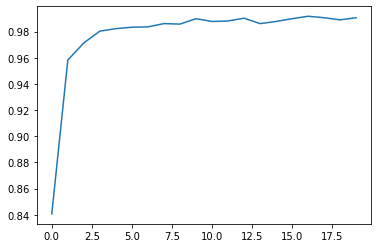

In [313]:
plt.plot(h.history['accuracy'])

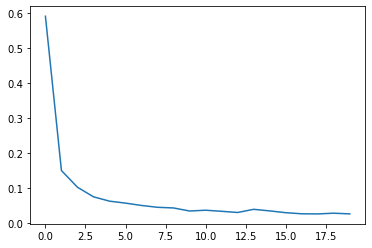

In [314]:
plt.plot(h.history['loss'])

In [315]:
model.evaluate(X_test[:-16], y_test[:-16], batch_size=batch_size)

62/62 [==============================] - 1s 2ms/step - loss: 0.0391 - accuracy: 0.9808


[0.03910887986421585, 0.9808467626571655]

In [316]:
y_pred = model.predict(X_test[:-16])
y_pred.argmax(axis=2)[:2]

array([[3],
       [2]])

In [317]:
y_pred.argmax(axis=1)[:2]

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [327]:
# y_pred[:2]#.sum(axis=2)

In [328]:
y_test.argmax(axis=2)[:2]

array([[3],
       [2]])

In [329]:
X_test[:2]

array([[[0.52873563],
        [0.64785789],
        [0.74712644],
        [0.45036573],
        [1.        ]],

       [[0.32320162],
        [1.        ],
        [0.23910841],
        [0.45997974],
        [0.62006079]]])

In [301]:
y_pos = order(X_test[..., 0])
y_idx = order(X_test[..., 0], True)

In [302]:
np.equal(y_pos, y_test).sum()

3999006

In [37]:
# y_pred = model.predict(X_test)

In [588]:
# np.equal(y_idx, y_pred.argmax(axis=1)).sum() / np.product(y_test.shape) 

0.9685

In [38]:
# np.equal(y_pos, y_pred.argmax(axis=2)).sum() / np.product(y_test.shape)

In [39]:
# y_pred = model.predict([[[1.0], [1.0], [0.5], [0.2], [0.2]]])
# y_pred.argmax(axis=2), y_pred.argmax(axis=1)

In [40]:
# y_pred = model.predict([[[1.0], [1.0], [1.0], [1.0], [1.0]]])
# y_pred.argmax(axis=2), y_pred.argmax(axis=1)

In [28]:
# cell = PointerLSTMCell(hidden_units)
# dec, _, _ = RNN(cell, name='decoder', return_sequences=True, return_state=True) \
#                     (enc, initial_state=[state_h, state_c], constants=enc)

In [29]:
# enc, state = K.zeros((32, 5, 64)), [K.zeros((32, 64)), K.zeros((32, 64))]
# p = PointerLSTM(64, return_sequences=True, return_state=True, name='decoder')
# _ = p.call(enc, initial_state=state, constants=[enc])

In [91]:
units = 2
att = Attention(units)
X_enc = K.constant( np.random.random((1, 5, units)) )
X_dec = K.constant( np.random.random((1, units)) )

# mask =  K.constant( [[False, False, False, True, True]] )
scores = att(X_enc, X_dec, mask=None)
scores

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[0.24137056, 0.22950119, 0.10816344, 0.2227062 , 0.19825862]],
      dtype=float32)>

In [92]:
l = LSTM(hidden_units, name='encoder', return_sequences=True, return_state=True)

In [93]:
enc, state_h, state_c = l(X_enc)

In [95]:
state_h == enc[:, -1]

<tf.Tensor: shape=(1, 64), dtype=bool, numpy=
array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]])>